In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os
import scipy.stats as stats

In [2]:
plt.style.use('tableau-colorblind10')

In [3]:
projdir = os.getcwd()
outdir = projdir + "/output/MonteCarlo"
plotdir = projdir + "/figures"

In [4]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/tempthresholds/figures


In [5]:
scenarios = [(1,26),(2,45),(4,60),(5,85)]
surge_option = 0
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

In [6]:
def subtract_ref_npv(dfO,dfG):
    nens = dfO.ens.max()
    npv_ref = np.zeros(nens)
    df1 = dfO.loc[dfO.time==1]
    for i in range(1,nens+1):
        # first 10 of the first timestep for a single ensemble member are OptimalCost
        # *10 to account for 10-year timestep vs annual costs
        npv_ref[i-1] = np.sum(np.array(df1.loc[df1.ens==i,"cost"])[:10])*10
    dfG.npv = dfG.npv - npv_ref
    return dfG

In [11]:
dfS = {scen : None for scen in scenarios} # global NPV, GMSL, temps, brick ensemble #s, 
#dfO = {scen : None for scen in scenarios} # global optimal cost, strategies for each segment

for (ssp,rcp) in scenarios:
    slrdir = outdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR/CIAM MC105/PostProcessing"
    dfS[(ssp,rcp)] = pd.read_csv(slrdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfO = pd.read_csv(slrdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfS[(ssp,rcp)] = subtract_ref_npv(dfO,dfS[(ssp,rcp)])

    dfR = pd.read_csv(slrdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfO = pd.read_csv(slrdir+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfR = dfR - dfO

    dfS[(ssp,rcp)] = dfS[(ssp,rcp)].join(dfR)
    dfS[(ssp,rcp)]["scenario"] = [str(ssp)+"-"+str(rcp)]*len(dfS[(ssp,rcp)])
    

In [12]:
dfN = pd.concat([dfS[(ssp,rcp)] for (ssp,rcp) in scenarios])

<br>

---

<br>

# todo - turn these into bar graphs with error bars

Global NPV of future adaptation costs at different thresholds

In [71]:
quants = [.05,.5,.95]
threshold_labels = ["<1.5 $^\circ$C", "1.5-2.5 $^\circ$C", "2.5-3.5 $^\circ$C", "3.5-4.5 $^\circ$C", ">4.5 $^\circ$C"]
threshold_colors = ["steelblue", "seagreen", "darkorange", "firebrick", "black"]

Heights for bar graph

In [20]:
npv_heights = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 4.5), "npv"].quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [25]:
npv_uppers  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 4.5), "npv"].quantile(quants[-1])])
npv_lowers  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 4.5), "npv"].quantile(quants[0])])

In [45]:
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights[t]), " (",np.round(npv_lowers[t]),"-",np.round(npv_uppers[t]),")")

< 1.5 $^\circ$C 1212.0  ( 1017.0 - 1394.0 )
1.5-2.5 $^\circ$C 1508.0  ( 1183.0 - 2389.0 )
2.5-3.5 $^\circ$C 1949.0  ( 1520.0 - 2694.0 )
3.5-4.5 $^\circ$C 3824.0  ( 3022.0 - 4395.0 )
>4.5 $^\circ$C 4097.0  ( 3598.0 - 4775.0 )


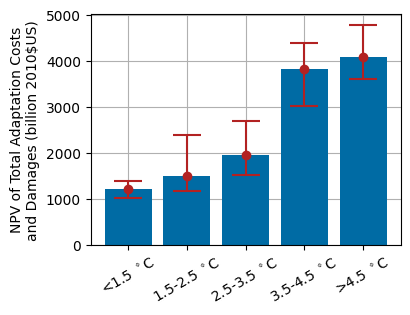

In [165]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
plt.bar(x=threshold_labels, height=npv_heights)
plt.errorbar(x=threshold_labels, y=npv_heights, 
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="firebrick", elinewidth=1.5, capsize=10, capthick=1.5)
plt.ylabel("NPV of Total Adaptation Costs\nand Damages (billion 2010$US)")
plt.xticks(rotation=30)
plt.grid(); ax.set_axisbelow(True)
fig.savefig("./figures/npv_global_bar.pdf", bbox_inches='tight');

# todo - histograms/kdes of above

In [68]:
npv_kde = [stats.gaussian_kde(dfN.loc[(dfN.temp2100 <= 1.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 4.5), "npv"])]

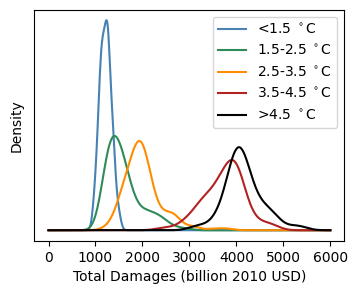

In [76]:
x = np.linspace(start=0, stop=6000, num=500)

fig,ax = plt.subplots(1,1,figsize=(4,3))
for t in range(len(threshold_labels)):
    plt.plot(x, npv_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
plt.xlabel("Total Damages (billion 2010 USD)"); plt.ylabel("Density"); plt.yticks([])
plt.legend()
fig.savefig("./figures/npv_global_kde.pdf", bbox_inches='tight');

KDEs of GMSL

(gmsl saved as relative to 1995-2014)

In [78]:
gmsl_kde = [stats.gaussian_kde(dfN.loc[(dfN.temp2100 <= 1.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 4.5), "gmsl2100"])]

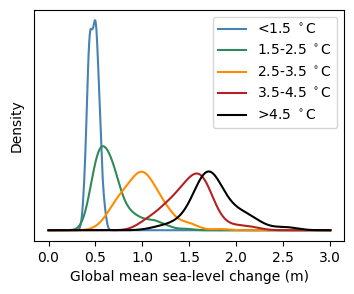

In [81]:
x = np.linspace(start=0, stop=3, num=500)

fig,ax = plt.subplots(1,1,figsize=(4,3))
for t in range(len(threshold_labels)):
    plt.plot(x, gmsl_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
plt.xlabel("Global mean sea-level change (m)"); plt.ylabel("Density"); plt.yticks([])
plt.legend()
fig.savefig("./figures/gmsl2100_kde.pdf", bbox_inches='tight');

combined version (NPV + GMSL)

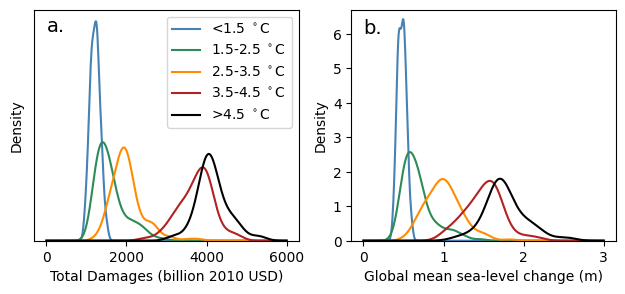

In [103]:
fig,ax = plt.subplots(1,2,figsize=(7.5,3))

# NPV
x = np.linspace(start=0, stop=6000, num=500)
for t in range(len(threshold_labels)):
    ax[0].plot(x, npv_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
ax[0].set_xlabel("Total Damages (billion 2010 USD)"); ax[0].set_ylabel("Density"); ax[0].set_yticks([])
ax[0].legend(); ax[0].text(0,0.0028,"a.",fontsize=14); ax[0].set_ylim([0,0.0031])

# GMSL
x = np.linspace(start=0, stop=3, num=500)
for t in range(len(threshold_labels)):
    ax[1].plot(x, gmsl_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
ax[1].set_xlabel("Global mean sea-level change (m)"); ax[1].set_ylabel("Density"); #ax[1].set_yticks([])
ax[1].text(0,6,"b.",fontsize=14); ax[1].set_ylim([0,6.7])
fig.savefig("./figures/npv+gmsl2100_kde.pdf", bbox_inches='tight');

# todo - same as above, but regional breakdown as %gdp as in the example below

Adapted from code in `raddleverse/CIAM_uncertainty_propagation` (Copyright, Wong, Rennels et al). citations:
* Wong, T. (2022). CIAM uncertainty propagation experiment codes and output files (v1.0.1). Zenodo. https://doi.org/10.5281/zenodo.6835363
*  Wong, T. E., Ledna, C., Rennels, L., Sheets, H., Errickson, F. C., Diaz, D., & Anthoff, D. (2022). Sea level and socioeconomic uncertainty drives high-end coastal adaptation costs. Earth's Future, 10, e2022EF003061. https://doi.org/10.1029/2022EF003061 

https://github.com/raddleverse/CIAM_uncertainty_propagation/blob/master/work_uncertainty_propagation/plotsAndAnalysis_uncertaintyPropagation.ipynb

In [104]:
scenarios = [(1,26),(2,45),(4,60),(5,85)]

gdp per capita (just first year (2010), all in US$2010)

In [106]:
ypcc = {scen : pd.read_csv(projdir+"/data/ssp/ypcc_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
dfGP = {scen : pd.DataFrame() for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["rgn"] = ypcc[scen].columns[1:]
    dfGP[scen]["gdp_per_capita"] = np.array(ypcc[scen].iloc[0][1:])

population (millions)

In [107]:
pop = {scen : pd.read_csv(projdir+"/data/ssp/pop_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["pop"] = np.array(pop[scen].iloc[0][1:])

get total gdp

In [108]:
for scen in scenarios:
    dfGP[scen]["gdp"] = dfGP[scen]["gdp_per_capita"]*dfGP[scen]["pop"]*1e6/1e9 
# 1e6 since population is in units of millions
# and /1e9 to get in units of billions US$2010

mapping of segments/regions in CIAM, to the 7 World Bank regions

gdp is in units of billions US$2010, since the NPV results are also billions

In [109]:
wbsegs = pd.read_csv(projdir+"/data/segments_regions_WB.csv")
regions = list(wbsegs["global region"].unique())
rgn_gdp = {scen : {} for scen in scenarios}
for scen in scenarios:
    for rgn in regions:
        rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
        rgn_gdp[scen][rgn] = dfGP[scen].loc[dfGP[scen]["rgn"].isin(rgns_this_rgn),"gdp"].sum()

compute npv as %gdp (in 2010)

In [130]:
for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    for rgn in regions:
        dfN.loc[dfN.scenario==scen_str, "npv/gpd "+rgn] = 100*dfN.loc[dfN.scenario==scen_str, rgn] / \
                                                        rgn_gdp[scen][rgn]

global NPV as %GDP

In [145]:
for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    dfN.loc[dfN.scenario==scen_str, "npv/gpd"] = 100*dfN.loc[dfN.scenario==scen_str, "npv"] / \
                                                    np.sum(list(rgn_gdp[scen].values()))

In [146]:
print(dfN.columns)

Index(['npv', 'gmsl2100', 'temp2100', 'retreat', 'brickEnsInd',
       'Europe and Central Asia', 'Middle East and North Africa',
       'Sub-Saharan Africa', 'Latin America and the Caribbean',
       'East Asia and Pacific', 'South Asia', 'North America', 'scenario',
       'npv/gpd Europe and Central Asia',
       'npv/gpd Middle East and North Africa', 'npv/gpd Sub-Saharan Africa',
       'npv/gpd Latin America and the Caribbean',
       'npv/gpd East Asia and Pacific', 'npv/gpd South Asia',
       'npv/gpd North America', 'npv/gpd'],
      dtype='object')


Heights for bar graphs

In [158]:
npv_heights_rgn = {rgn : None for rgn in regions+["global"]}

for rgn in regions:
    npv_heights_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd "+rgn].quantile(0.5)])
npv_heights_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd"].quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [157]:
npv_uppers_rgn = {rgn : None for rgn in regions+["global"]}
npv_lowers_rgn = {rgn : None for rgn in regions+["global"]}

for rgn in regions:
    npv_uppers_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd "+rgn].quantile(quants[-1])])
    npv_lowers_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd "+rgn].quantile(quants[0])])
npv_uppers_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd"].quantile(quants[-1])])
npv_lowers_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd"].quantile(quants[0])])

# TODO HERE NOW

AttributeError: 'numpy.ndarray' object has no attribute 'set_axisbelow'

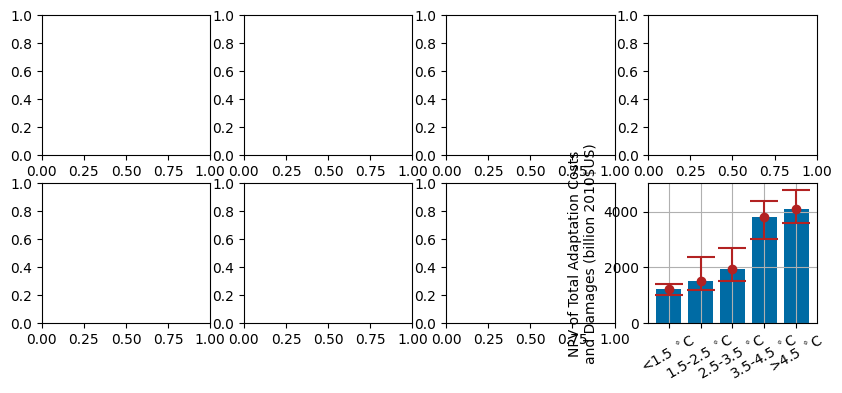

In [164]:
fig,ax = plt.subplots(2,4,figsize=(10,4))
plt.bar(x=threshold_labels, height=npv_heights)
plt.errorbar(x=threshold_labels, y=npv_heights, 
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="firebrick", elinewidth=1.5, capsize=10, capthick=1.5)
plt.ylabel("NPV of Total Adaptation Costs\nand Damages (billion 2010$US)")
plt.xticks(rotation=30)
plt.grid(); ax.set_axisbelow(True)
fig.savefig("./figures/npv_regions_bar.pdf", bbox_inches='tight');

(array([0.92300715, 1.53834525, 0.96146578, 0.46150358, 0.26921042,
        0.19229316, 0.26921042, 0.11537589, 0.07691726, 0.03845863]),
 array([1.21926882, 1.42563363, 1.63199843, 1.83836324, 2.04472804,
        2.25109285, 2.45745765, 2.66382246, 2.87018726, 3.07655206,
        3.28291687]),
 <BarContainer object of 10 artists>)

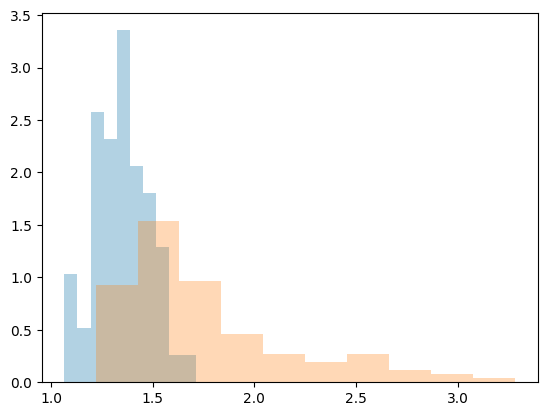

In [137]:
plt.hist(dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd North America"], density=True, alpha=0.3)
plt.hist(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd North America"], density=True, alpha=0.3)

In [139]:
print(dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd Sub-Saharan Africa"].quantile([0.05,0.5,0.95]))
print(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd Sub-Saharan Africa"].quantile([0.05,0.5,0.95]))
print(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd Sub-Saharan Africa"].quantile([0.05,0.5,0.95]))

0.05    2.209921
0.50    2.414013
0.95    2.657735
Name: npv/gpd Sub-Saharan Africa, dtype: float64
0.05    2.397927
0.50    2.733505
0.95    3.735236
Name: npv/gpd Sub-Saharan Africa, dtype: float64
0.05    2.729318
0.50    3.192078
0.95    4.080491
Name: npv/gpd Sub-Saharan Africa, dtype: float64


In [140]:
print(dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd North America"].quantile([0.05,0.5,0.95]))
print(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd North America"].quantile([0.05,0.5,0.95]))
print(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd North America"].quantile([0.05,0.5,0.95]))

0.05    1.126056
0.50    1.360886
0.95    1.560109
Name: npv/gpd North America, dtype: float64
0.05    1.294893
0.50    1.626386
0.95    2.638663
Name: npv/gpd North America, dtype: float64
0.05    1.757845
0.50    2.389653
0.95    3.083165
Name: npv/gpd North America, dtype: float64


(array([1.08701195, 1.44934926, 0.92597314, 0.52337612, 0.32207761,
        0.20129851, 0.28181791, 0.12077911, 0.0805194 , 0.0805194 ]),
 array([2.3428006 , 2.5399334 , 2.73706621, 2.93419901, 3.13133182,
        3.32846462, 3.52559743, 3.72273023, 3.91986304, 4.11699584,
        4.31412865]),
 <BarContainer object of 10 artists>)

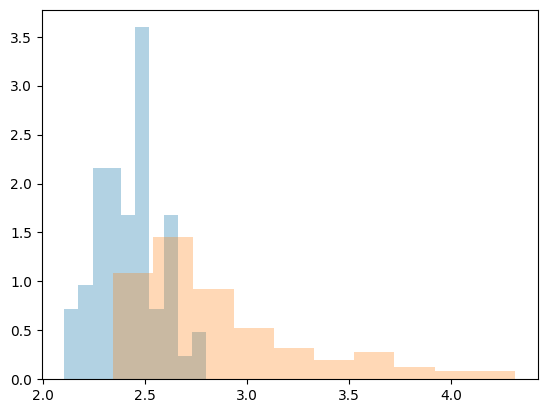

In [138]:
plt.hist(dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd Sub-Saharan Africa"], density=True, alpha=0.3)
plt.hist(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd Sub-Saharan Africa"], density=True, alpha=0.3)